In [5]:
!pip install pyvirtualdisplay Pillow



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# SUMO Setups

In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from dotenv import load_dotenv
from gymnasium import spaces
import matplotlib.patches as patches
import shutil

SUMO_HOME = 'C:\\Program Files (x86)\\Eclipse\\Sumo'

os.environ['SUMO_HOME'] = SUMO_HOME

# Print the SUMO_HOME environment variable to verify
print("SUMO_HOME is set to:", os.environ.get('SUMO_HOME'))

# Check if the SUMO_HOME path exists
print("Does SUMO_HOME exist?", os.path.exists(os.environ.get('SUMO_HOME')))


# # Define file paths 
# net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
# route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
# out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'
# config_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.sumocfg'

# Define file paths Nishanth (temp)
net_file = 'C:/Users/naren/ReinforcementLearning_FinalCourseProject/nets/single_intersection_simple.net.xml'
route_file = 'C:/Users/naren/ReinforcementLearning_FinalCourseProject/nets/single_intersection_simple.rou.xml'
out_csv_name = 'C:/Users/naren/ReinforcementLearning_FinalCourseProject/nets/A3C_trial.csv'
config_file = 'C:/Users/naren/ReinforcementLearning_FinalCourseProject/nets/single_intersection_simple.sumocfg'


SUMO_HOME is set to: C:\Program Files (x86)\Eclipse\Sumo
Does SUMO_HOME exist? True


## Importing Required libraries

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import os
from dotenv import load_dotenv
import sumo_rl
import traci

# Environment Setup

In [3]:
class Environment:
    def __init__(self, env_name, route_file, net_file, out_csv_name, render_mode='human', num_seconds=100000):
        self.env_name = env_name
        self.use_gui = True if render_mode == 'human' else False
        self.route_file = route_file
        self.net_file = net_file
        self.out_csv_name = out_csv_name
        self.env = gym.make(
                        env_name,
                        net_file=net_file,
                        route_file=route_file,
                        out_csv_name=out_csv_name,
                        use_gui=self.use_gui,
                        num_seconds=num_seconds
                    )
     
        self.state, _ = self.env.reset()
        self.done = False
        self.observation_space = self.env.observation_space.shape[0]
        self.action_space = self.env.action_space
        # print(dir(self.env))
        self.traffic_signals = self.env.unwrapped.traffic_signals
    
    def reset(self):
        self.state, _ = self.env.reset()
        self.done = False
        return self.state
    
    def custom_reward(self, traffic_signal, reward_type='average_speed', reward_method='simple'):
        # print("Inside custom reward method")
        if reward_method == 'simple':
            match reward_type:
                case 'average_speed':
                    return traffic_signal.get_avgerage_speed()
                case 'congesion':
                    return -1 * traffic_signal.get_pressure()
                case 'emissions':
                    return -1* traffic_signal.get_emission_co2()
                case 'throughput':
                    return traffic_signal.get_throughput()

        else:
            # Weighted sum of the metrics
            reward = 0
            if weights is None:
                weights = {
                    'average_speed': 0.4,
                    'waiting_time': 0.3,
                    'emissions': 0.2,
                    'throughput': 0.1
                }

            # Calculate individual rewards
            average_speed = traffic_signal.get_average_speed()
            waiting_time = -1* traffic_signal._diff_waiting_time_reward()
            total_queue = -1 * traffic_signal.get_total_queued()
            congesion = traffic_signal.get_pressure()

            print(average_speed, waiting_time, total_queue, congesion)
            weighted_reward = (
                weights['average_speed'] * average_speed +
                weights['waiting_time'] * waiting_time +
                weights['emissions'] * total_queue +
                weights['throughput'] * congesion
            )

            return weighted_reward
            
            
    def step(self, action):
        # print("Inside step method")
        next_state, reward, terminated, truncated, info = self.env.step(action)
        # print("Step taken", next_state, terminated, truncated, info)

        # print("Traffic signals:", list(self.traffic_signals.values())[0])
        # traffic_signal = list(self.traffic_signals.values())[0]
        # print("Pressure:", traffic_signal.get_pressure())
        # # print(traffic_signal.get_average_speed(), traffic_signal.get_total_queued(), traffic_signal._diff_waiting_time_reward(), traffic_signal.get_pressure())
        # reward = self.custom_reward(traffic_signal, reward_type='congesion', reward_method='simple')
        # print("Reward:", reward)

        self.state = next_state
        self.done = terminated
        return next_state, reward, self.done or truncated
    
    def render(self):
        self.env.render()
    
    def close(self):
        try:
            self.env.close()
            if traci.isLoaded():
                traci.close()
            print("Env and Traci closed successfully.")
        except Exception as e:
            print("Error while closing the environment:", e)
    
    def get_state(self):
        return self.state
    
    


## Random Agent Run Basic

## Running Environment (Simple Intersection)

In [5]:
# Define paths to the network and route files (Buffalo Road Intersection)

# net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
# route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
# out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'


# Using Custom simple Traffic Intersection
nets_dir = 'nets'

file_name = 'single_intersection_simple'
out_csv_name = f'{file_name}.csv'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')
out_csv_name = os.path.join(nets_dir, f'{file_name}.csv')

file_exists = lambda file_path: os.path.exists(file_path)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")


# Instantiate the environment
sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=100000)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space.n)
print("Initial State:", sumo_env.state)

max_steps = 100

try:
    print("action space", sumo_env.action_space)
    for step in range(max_steps):
        # sumo_env.render()
        action = sumo_env.env.action_space.sample()
        next_state, reward, done = sumo_env.step(action)
        print("Action ", action, " Reward ", reward, " Done ", done, "observation", next_state)
        
        if done:
            sumo_env.reset()
            break

except KeyboardInterrupt:
    print("Keyboard interrupt detected. Closing the environment.")

except Exception as e:
    print("Error occurred:", e)

finally:
    sumo_env.close()

Observation Space: 11
Action Space: 2
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
action space Discrete(2)
Action  0  Reward  0.0  Done  False observation [1.         0.         0.         0.05048805 0.         0.10567101
 0.05283551 0.         0.         0.         0.        ]
Action  1  Reward  0.0  Done  False observation [1.         0.         1.         0.05048805 0.05048805 0.10567101
 0.10567101 0.         0.         0.         0.        ]
Action  1  Reward  0.0  Done  False observation [0.         1.         0.         0.05048805 0.05048805 0.10567101
 0.15850651 0.         0.         0.         0.        ]
Action  0  Reward  -0.06  Done  False observation [0.         1.         1.         0.1009761  0.1009761  0.15850651
 0.15850651 0.05048805 0.05048805 0.         0.        ]
Action  1  Reward  -0.1  Done  False observation [0.         1.         1.         0.1009761  0.1009761  0.15850651
 0.15850651 0.05048805 0.05048805 0.         0.        ]
Action  0  Reward  0.16 

A2C implementation:

In [5]:
from torch import nn

input_nodes = 128

class ActorCritic(nn.Module):
    def __init__(self, observation_size, action_size, hidden_size=128):
        super(ActorCritic, self).__init__()
        self.fc = nn.Linear(observation_size, hidden_size)
        self.actor = nn.Linear(hidden_size, action_size)
        self.critic = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc(x))
        action_probs = torch.softmax(self.actor(x), dim=-1)
        state_value = self.critic(x)
        return action_probs, state_value

In [ ]:
class A2CAgent:
    def __init__(self, env, gamma=0.99, learning_rate=1e-3):
        self.env = env
        self.gamma = gamma
        self.policy = ActorCritic(env.observation_space, env.action_space.n)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
    
    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs, _ = self.policy(state)
        action = torch.multinomial(action_probs, 1).item()
        return action
    
    def choose_greedy_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs, _ = self.policy(state)
        action = torch.argmax(action_probs).item()  #choosing action with the highest probability
        return action

    def compute_returns(self, rewards, dones, next_value):
        returns = []
        R = next_value
        for r, done in zip(reversed(rewards), reversed(dones)):
            R = r + self.gamma * R * (1 - done)
            returns.insert(0, R)
        return torch.tensor(returns)

    def train(self, n_episodes, max_steps, batch_size):

        p_bar = tqdm(range(n_episodes), colour='green', desc='Training progress', unit='Episode')

        try:

            for episode in p_bar:
                state = self.env.reset()
                log_probs, values, rewards, dones, epsilons = [], [], [], [], []
                total_reward = 0
                done = False

                while not done:
                    action = self.choose_action(state)
                    next_state, reward, done = self.env.step(action)
                    total_reward += reward
                    
                    # Store experience
                    state_tensor = torch.FloatTensor(state).unsqueeze(0)
                    action_prob, value = self.policy(state_tensor)
                    log_prob = torch.log(action_prob.squeeze(0)[action])
                    
                    log_probs.append(log_prob)
                    values.append(value)
                    rewards.append(reward)
                    dones.append(done)
                    
                    state = next_state
                    if done:
                        break
                
                # Compute loss
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                _, next_value = self.policy(next_state_tensor)
                returns = self.compute_returns(rewards, dones, next_value.item())
                values = torch.cat(values).squeeze()
                
                advantage = returns - values
                actor_loss = -(torch.stack(log_probs) * advantage.detach()).mean()
                critic_loss = advantage.pow(2).mean()
                loss = actor_loss + critic_loss
                
                # Update network
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
                self.optimizer.step()

        except traci.exceptions.FatalTraCIError as e:
            print("TraCI error:", e)
        
        except KeyboardInterrupt:
            print("Training interrupted by the user.")

        except Exception as e:
            print(f"Error occurred in episode {episode}, step {step_}: {e}")
            raise

        finally:
            print("Training completed.")
            self.env.close()
        

            
            # print(f"Episode {episode + 1}, Total Reward: {total_reward}, Loss: {loss.item()}")

        torch.save(self.policy.state_dict(), 'a2c_trained_model.pth')
        print("Model saved as 'a2c_trained_model.pth'")
        return rewards

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Train the agent
nets_dir = 'nets'

file_name = 'single_intersection_simple'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}.rou.xml')
out_csv_name = os.path.join(nets_dir+"/results_csv", f'{file_name}.a2c.passenger.csv')

file_exists = lambda file_path: os.path.exists(file_path)

results_dir = os.path.join(nets_dir, 'results_csv')
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")

num_seconds = 500
episodes = 1000



sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=num_seconds)
agent = A2CAgent(sumo_env, gamma=0.99, learning_rate=1e-3)
a2c_rewards = agent.train(n_episodes=1000, max_steps=500, batch_size=64)


Training progress:   0%|          | 1/1000 [00:08<2:14:11,  8.06s/Episode]

Episode 1, Total Reward: -1.83, Loss: 1.6101446151733398


Training progress:   0%|          | 2/1000 [00:15<2:05:10,  7.53s/Episode]

Episode 2, Total Reward: -0.6499999999999995, Loss: 0.953195333480835


Training progress:   0%|          | 3/1000 [00:23<2:11:12,  7.90s/Episode]

Episode 3, Total Reward: -5.56, Loss: 5.280036926269531


Training progress:   0%|          | 4/1000 [00:31<2:13:25,  8.04s/Episode]

Episode 4, Total Reward: -0.76, Loss: 4.618537902832031


Training progress:   0%|          | 5/1000 [00:40<2:15:12,  8.15s/Episode]

Episode 5, Total Reward: -0.87, Loss: 2.136017084121704


Training progress:   1%|          | 6/1000 [00:48<2:15:11,  8.16s/Episode]

Episode 6, Total Reward: -1.48, Loss: 12.474971771240234


Training progress:   1%|          | 7/1000 [00:56<2:12:35,  8.01s/Episode]

Episode 7, Total Reward: -1.54, Loss: 0.41330456733703613


Training progress:   1%|          | 8/1000 [01:03<2:10:26,  7.89s/Episode]

Episode 8, Total Reward: -4.76, Loss: 4.155727386474609


Training progress:   1%|          | 8/1000 [01:07<2:18:47,  8.39s/Episode]


KeyboardInterrupt: 

## Evaluation

In [20]:
def rewards_per_episode_plot(rewards_per_ep, title):
    episodes = np.arange(1, len(rewards_per_ep) + 1)
    rewards = np.array(rewards_per_ep)

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4)
    plt.title(f'Rewards per Episode {title}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.xticks(range(0, len(episodes)+1, max(1, len(episodes)//10)))

    plt.tight_layout()
    plt.show()

def rewards_per_episode_plot_2(rewards_per_ep, environment_type, epsilons=None, window_size=10):
    """
    Plots rewards per episode with optional smoothing.
    
    Args:
        rewards_per_ep (dict): A dictionary where keys are episodes and values are rewards.
        environment_type (str): The type of environment (for plot title).
        epsilons (list, optional): Epsilon values per episode, if you'd like to include them in the plot. Default is None.
        window_size (int, optional): The window size for moving average smoothing. Default is 10.
    """
    episodes = np.array(list(rewards_per_ep.keys())).flatten()
    rewards = np.array(list(rewards_per_ep.values())).flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4, label='Rewards per Episode')

    # Moving average for smoothing
    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(episodes[:len(moving_avg)], moving_avg, color='r', label=f'Moving Avg (window={window_size})')

    plt.title(f'Rewards per Episode {environment_type}', fontsize=20)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True)
    
    # Include epsilon plot if provided
    if epsilons:
        ax2 = plt.gca().twinx()
        ax2.plot(episodes, epsilons, color='g', alpha=0.6, linestyle='--', label='Epsilon')
        ax2.set_ylabel('Epsilon', fontsize=14)
        ax2.tick_params(axis='y', labelsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()
    return plt


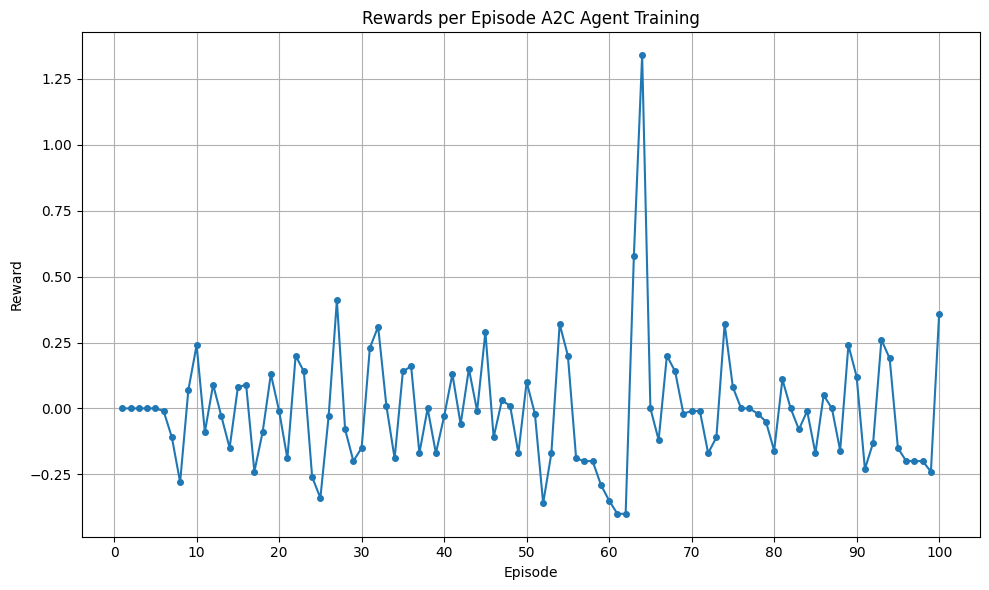

In [21]:
# print("Average Rewards:", np.mean(rewards))
rewards_per_episode_plot(a2c_rewards, "A2C Agent Training")

## Greedy Evaluation

In [ ]:
def greedy_agent(agent, model, env, n_episodes=100):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0)  # Add batch dimension
        action_probs, _ = model(state)  # Forward pass through the policy
        greedy_action = torch.argmax(action_probs, dim=1).item()  # Select max probability action
    return greedy_action


In [151]:
model = DQN(sumo_env.observation_space, sumo_env.action_space.n)
model.load_state_dict(torch.load('sumo_dqn.pth'))

greedy_avg_rewards_over_eps, greedy_rewards_per_eps, epsilon_values = greedy_agent(agent,  model, sumo_env ,n_episodes=100)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_38112\690269224.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sumo_dqn.pth'))


Observation size Network 11
Action size Network 2


Testing Progress:   0%|          | 0/100 [00:00<?, ?Episode/s]

Testing Progress: 100%|██████████| 100/100 [09:30<00:00,  5.71s/Episode]

{0: -0.2, 1: -0.79, 2: -0.10000000000000012, 3: -0.36, 4: -0.2200000000000001, 5: -0.05000000000000003, 6: -0.14999999999999988, 7: -0.86, 8: -0.66, 9: -0.4899999999999999, 10: -0.45000000000000023, 11: -1.39, 12: -0.41, 13: -0.48, 14: -0.21000000000000002, 15: -0.34999999999999987, 16: -0.14000000000000012, 17: -0.26, 18: -0.45, 19: -0.66, 20: -0.15, 21: -0.6, 22: -0.34, 23: -0.42, 24: -0.73, 25: -0.18, 26: -0.1200000000000001, 27: -0.51, 28: -0.2699999999999999, 29: -0.06, 30: -0.3800000000000002, 31: -0.5699999999999998, 32: -0.33, 33: -0.7900000000000001, 34: -0.05, 35: -0.3900000000000001, 36: -0.22, 37: -1.1100000000000003, 38: -0.040000000000000216, 39: -0.16000000000000023, 40: -0.030000000000000006, 41: -0.52, 42: -0.9, 43: -0.68, 44: -0.27, 45: -0.78, 46: -0.55, 47: -0.5799999999999998, 48: -0.26, 49: -0.13, 50: -0.020000000000000004, 51: -0.19, 52: -0.55, 53: -0.22, 54: -0.87, 55: -0.6199999999999998, 56: -0.38, 57: -0.29, 58: -0.62, 59: -0.4, 60: -0.8000000000000002, 61: -0

Avg Rewards per episode for Greedy Agent:  -1.4941


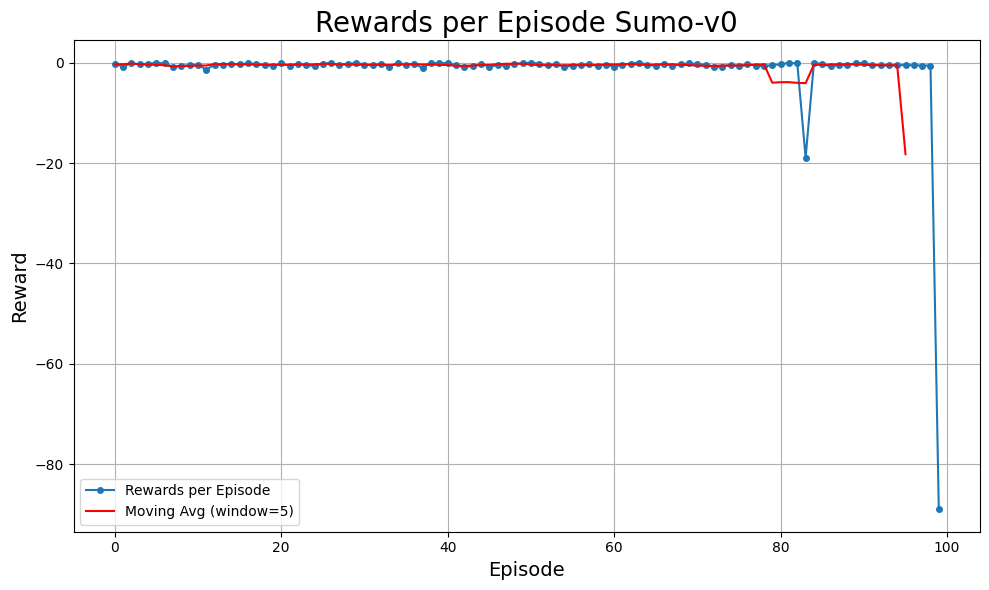

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
# print("Avg Rewards per episode for Greedy Agent: ", greedy_avg_rewards_over_eps)
rewards_per_episode_plot_2(greedy_rewards_per_eps, 'Sumo-v0', window_size=5)